# Mapping wetland intrinsic potential and classifying types

### Background
The main function of this notebook is to utilise the trained Random Forest classifier from Notebook 4 to predict the landscape’s wetland intrinsic potential from the binary model and then classify wetland areas into classes for a specific area of interest.


In [14]:
%matplotlib inline

import os
import gc
import json
import random
import datacube
import subprocess
import xarray as xr
from tqdm import tqdm
import requests
import rioxarray as rxr
import geopandas as gpd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from joblib import load
from odc.dscache.tools import tiling
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap,BoundaryNorm
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from datacube.testutils.io import rio_slurp_xarray

from classification import predict_xr
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, display_map


## Create Dask cluster for running predictions
We use dask to parallel and speed up processing

In [3]:
# Set up a dask cluster
create_local_dask_cluster()

/home/jesse/Projects/TealWaters/WIP_implementations/WIP_mpho/venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37727 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37727/status,
Dashboard: http://127.0.0.1:37727/status,Workers: 1
Total threads: 20,Total memory: 59.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38217,Workers: 0
Dashboard: http://127.0.0.1:37727/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40543,Total threads: 20
Dashboard: http://127.0.0.1:36883/status,Memory: 59.76 GiB
Nanny: tcp://127.0.0.1:37369,


## Load the model 
We use the model trained and saved in the [Train_Classification_Algorithm](04_Train_Classification_Algorithm.ipynb).

### Load area of interest (AOI)

In [2]:
SKYKOMISH_HUC8_ID = "17110009"
prefix = SKYKOMISH_HUC8_ID  # Specify the desired prefix


def load_huc_boundary(huc_id) -> gpd.GeoDataFrame:
    url = "https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/4/query"
    params = {
        "where": f"HUC8='{huc_id}'",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "geojson",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    return response.json()


aoi = load_huc_boundary(SKYKOMISH_HUC8_ID)

# Create a geopolygon and geodataframe of the area of interest
geom = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geom_gdf = gpd.GeoDataFrame(geometry=[geom], crs=geom.crs)

In [3]:
# Get the latitude and longitude range of the geopolygon
lat_range = (geom_gdf.total_bounds[1], geom_gdf.total_bounds[3])
lon_range = (geom_gdf.total_bounds[0], geom_gdf.total_bounds[2])
display_map(x=lon_range, y=lat_range)

In [4]:
# Check if both binary and type models are available
if os.path.exists(f"results/{prefix}_Binary_RF_model.joblib") and os.path.exists(
    f"results/{prefix}_Type_RF_model.joblib"
):
    binary_model = load(f"results/{prefix}_Binary_RF_model.joblib").set_params(n_jobs=1)
    print("Loaded binary random forest model:\n", binary_model)

    type_model = load(f"results/{prefix}_Type_RF_model.joblib").set_params(n_jobs=1)
    print("Loaded type random forest model:\n", type_model)
elif os.path.exists(f"results/{prefix}_Binary_RF_model.joblib"):
    binary_model = load(f"results/{prefix}_Binary_RF_model.joblib").set_params(n_jobs=1)
    print("Loaded binary random forest model:\n", binary_model)
elif os.path.exists(f"results/{prefix}_Type_RF_model.joblib"):
    type_model = load(f"results/{prefix}_Type_RF_model.joblib").set_params(n_jobs=1)
    print("Loaded type random forest model:\n", type_model)
else:
    print("No trained models found.")

Loaded binary random forest model:
 RandomForestClassifier(max_features='log2', n_estimators=50, n_jobs=1,
                       random_state=1)
Loaded type random forest model:
 RandomForestClassifier(max_features='log2', n_jobs=1, random_state=1)


In [5]:
# Define the file paths for importing the feature names
binary_features_path = f"results/{prefix}_binary_model_features.json"
type_features_path = f"results/{prefix}_type_model_features.json"

# Load binary model feature names from JSON if binary model exists
if os.path.exists(binary_features_path):
    with open(binary_features_path, "r") as binary_file:
        binary_features_dict = json.load(binary_file)
    binary_feature_names = binary_features_dict["features"]
    print("Loaded binary model features.")
else:
    print("No binary model features found.")

# Load type model feature names from JSON if type model exists
if os.path.exists(type_features_path):
    with open(type_features_path, "r") as type_file:
        type_features_dict = json.load(type_file)
    type_feature_names = type_features_dict["features"]
    print("Loaded type model features.")
else:
    print("No type model features found.")

Loaded binary model features.
Loaded type model features.


## Apply classification model to predict wetlands in the AOI

In [11]:
skip_existing = False
output_folder = "results"
binary_tiles_pred_folder = os.path.join(
    output_folder, f"{prefix}/binary_tiles_predicted"
)
os.makedirs(binary_tiles_pred_folder, exist_ok=True)
dask_chunks = {"x": 2500, "y": 2500}

## Binary classification

In [16]:
from pathlib import Path
import rioxarray as rx


def load_training_data():
    return xr.merge(
        [
            rx.open_rasterio(f).squeeze(drop=True).to_dataset(name=f.stem)
            for f in Path("data/terrain_attributes").glob("*.tif")
        ]
    )


data = load_training_data()

output_filename = os.path.join(
    binary_tiles_pred_folder,
    f"{prefix}_wetland_binary_prediction.tif",
)
probabilities_filename = os.path.join(
    binary_tiles_pred_folder,
    f"{prefix}_wetland_binary_probabilities.tif",
)
# Only keep features that are in the original list of columns
data = data[binary_feature_names]

# Predict using the imported model
predicted = predict_xr(binary_model, data, proba=True, clean=True, return_input=True)

# Set the no data value
NODATA = 255

# Mask the predictions
print("    Preparing predictions")
binary_wetland_predictions = mask(predicted.Predictions, geom)
binary_wetland_predictions.attrs["nodata"] = NODATA

# Write predictions to COG
print(f"    Writing predictions to {output_filename}")
write_cog(
    binary_wetland_predictions,
    fname=output_filename,
    overwrite=True,
    nodata=NODATA,
)

# Mask the probabilities
print("    Preparing probabilities")
binary_wetland_probabilities = mask(predicted.Probabilities[..., :, 1], geom)
binary_wetland_probabilities.attrs["nodata"] = NODATA
binary_wetland_probabilities = binary_wetland_probabilities.where(
    (binary_wetland_probabilities >= 0) & (binary_wetland_probabilities <= 100)
)

print(f"    Writing probabilities to {probabilities_filename}")
write_cog(
    binary_wetland_probabilities,
    fname=probabilities_filename,
    overwrite=True,
    nodata=NODATA,
)

predicting...
   probabilities...
   input features...
    Preparing predictions
    Writing predictions to results/17110009/binary_tiles_predicted/17110009_wetland_binary_prediction.tif


/tmp/ipykernel_3571616/1461254840.py:40: ODC2DeprecationWarning: Call to deprecated function (or staticmethod) write_cog. (This method has been moved to odc-geo.)
-- Deprecated since version 1.9.0.
  write_cog(


    Preparing probabilities
    Writing probabilities to results/17110009/binary_tiles_predicted/17110009_wetland_binary_probabilities.tif


/tmp/ipykernel_3571616/1461254840.py:56: ODC2DeprecationWarning: Call to deprecated function (or staticmethod) write_cog. (This method has been moved to odc-geo.)
-- Deprecated since version 1.9.0.
  write_cog(


PosixPath('results/17110009/binary_tiles_predicted/17110009_wetland_binary_probabilities.tif')

#### Plot the wetland predicition and probabilities

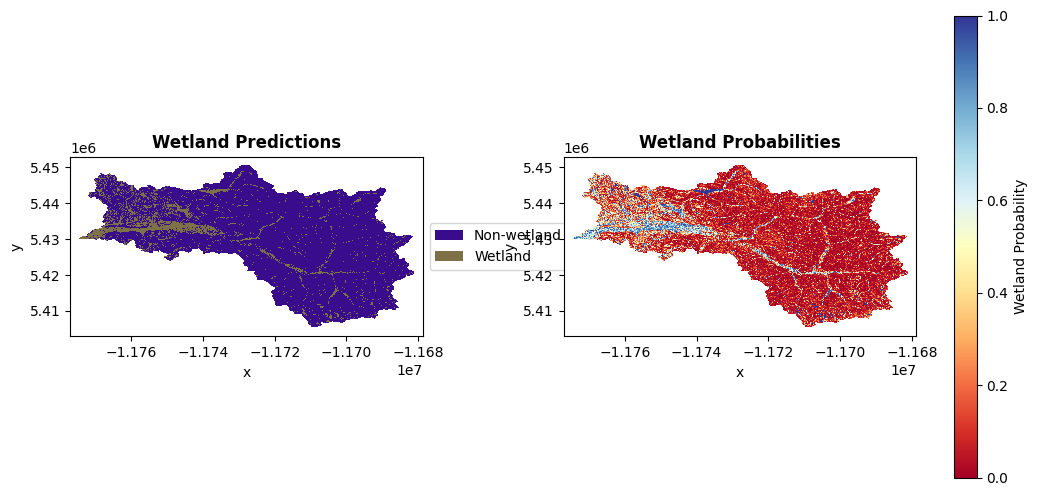

In [19]:
# Create a new label dictionary
labels_dict_binary = {"Non-wetland": 0, "Wetland": 1}

# Generate random colors for each class (excluding class 0)
random.seed(42)  # Set a seed for reproducibility
class_colors = {
    class_name: f"#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}"
    for class_name in labels_dict_binary
}

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size if needed

# Plot wetland predictions
sorted_classes = sorted(labels_dict_binary, key=lambda x: labels_dict_binary[x])
cmap = ListedColormap([class_colors[class_name] for class_name in sorted_classes])

# Plot wetland predictions
binary_wetland_predictions.plot.imshow(
    ax=axes[0], cmap=cmap, add_colorbar=False, interpolation="none"
)
axes[0].set_title("Wetland Predictions", fontweight="bold")
axes[0].set_aspect("equal")

# Plot clipped wetland probabilities
im = binary_wetland_probabilities.plot.imshow(
    ax=axes[1], cmap="RdYlBu", add_colorbar=False, interpolation="none"
)
axes[1].set_title("Wetland Probabilities", fontweight="bold")
axes[1].set_aspect("equal")

# Add legend to the first subplot
patches_list = [
    Patch(facecolor=class_colors[class_name]) for class_name in sorted_classes
]
legend = axes[0].legend(
    patches_list,
    [class_name for class_name in sorted_classes],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Adjust spacing
plt.subplots_adjust(wspace=0.4)

# Add colorbar outside the subplot
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.05, pad=0.04
)
cbar.set_label("Wetland Probability")

plt.show()

### Independent accuaracy assessment 

In [30]:
# Load the testing points GeoDataFrame
testing_points = gpd.read_file(f"data/{prefix}_testing_samples.geojson").to_crs(
    binary_wetland_predictions.rio.crs
)

# Replace non-zero values in the 'class_id' column with 1
testing_points["class_id_binary"] = testing_points["class_id"].apply(
    lambda x: 1 if x != 0 else 0
)
# Insert the new column at the second position
testing_points.insert(1, "class_id_binary", testing_points.pop("class_id_binary"))

# Sample the predictions and probabilities at testing points
sampled_predictions = []
sampled_probabilities = []

for point in testing_points.geometry:
    # Extract the point coordinates
    x, y = point.x, point.y

    # Sample the binary predictions and probabilities at the point coordinates
    prediction = binary_wetland_predictions.sel(x=x, y=y, method="nearest").item()
    probability = binary_wetland_probabilities.sel(x=x, y=y, method="nearest").item()

    # Append the sampled values
    sampled_predictions.append(prediction)
    sampled_probabilities.append(probability)

# Add the sampled values as new columns in the GeoDataFrame
testing_points["sampled_predictions"] = sampled_predictions
testing_points["sampled_probabilities"] = sampled_probabilities

# Calculate the number of correctly classified samples
correct_count = (
    testing_points["sampled_predictions"] == testing_points["class_id_binary"]
).sum()

# Calculate the total number of samples
total_count = len(testing_points)

# Calculate the accuracy as a percentage
accuracy_percentage = (correct_count / total_count) * 100

# Print the accuracy percentage
print(f"Overall Accuracy: {accuracy_percentage:.2f}%")

Overall Accuracy: 89.50%


## Wetland Type classification
#### Applied to the wetland class

In [ ]:
thresholded_binary_wetland_probabilities = binary_wetland_probabilities.where(
    binary_wetland_probabilities >= 50
)
data = data.where(thresholded_binary_wetland_probabilities != 0)

#### Merge the tiles and export the final wetland predicitons and probabilities

In [31]:
tiles_pred_folder = os.path.join(output_folder, f"{prefix}/type_tiles_predicted")
# Check if type_model exists
if "type_model" in locals():
    # Predict using the imported model
    predicted = predict_xr(type_model, data, proba=True, clean=True)
    # Set the no data value
    NODATA = 255

    # Mask the predictions
    print("    Preparing predictions")
    wetland_type_predictions = mask(predicted.Predictions, geom)
    wetland_type_predictions.attrs["nodata"] = NODATA

    out_mosaic_prediction = (
        f"{output_folder}/{prefix}/{prefix}_wetland_type_prediction.tif"
    )
    # Write predictions to COG
    print(f"    Writing predictions to {output_filename}")
    write_cog(
        wetland_type_predictions,
        fname=out_mosaic_prediction,
        overwrite=True,
        nodata=NODATA,
    )

    out_mosaic_probabilities = (
        f"{output_folder}/{prefix}/{prefix}_wetland_type_probabilities.tif"
    )
    # Mask the probabilities
    print("    Preparing probabilities")
    wetland_type_probabilities = mask(predicted.Probabilities[..., :, 1], geom)
    wetland_type_probabilities.attrs["nodata"] = NODATA
    wetland_type_probabilities = wetland_type_probabilities.where(
        (wetland_type_probabilities >= 0) & (wetland_type_probabilities <= 100)
    )

    print(f"    Writing probabilities to {probabilities_filename}")
    write_cog(
        wetland_type_probabilities,
        fname=out_mosaic_probabilities,
        overwrite=True,
        nodata=NODATA,
    )

predicting...
   probabilities...
    Preparing predictions
    Writing predictions to results/17110009/binary_tiles_predicted/17110009_wetland_binary_prediction.tif


/tmp/ipykernel_3571616/3588042247.py:19: ODC2DeprecationWarning: Call to deprecated function (or staticmethod) write_cog. (This method has been moved to odc-geo.)
-- Deprecated since version 1.9.0.
  write_cog(


    Preparing probabilities
    Writing probabilities to results/17110009/binary_tiles_predicted/17110009_wetland_binary_probabilities.tif


/tmp/ipykernel_3571616/3588042247.py:38: ODC2DeprecationWarning: Call to deprecated function (or staticmethod) write_cog. (This method has been moved to odc-geo.)
-- Deprecated since version 1.9.0.
  write_cog(


#### Plot the wetland type predicitions and probabilities¶

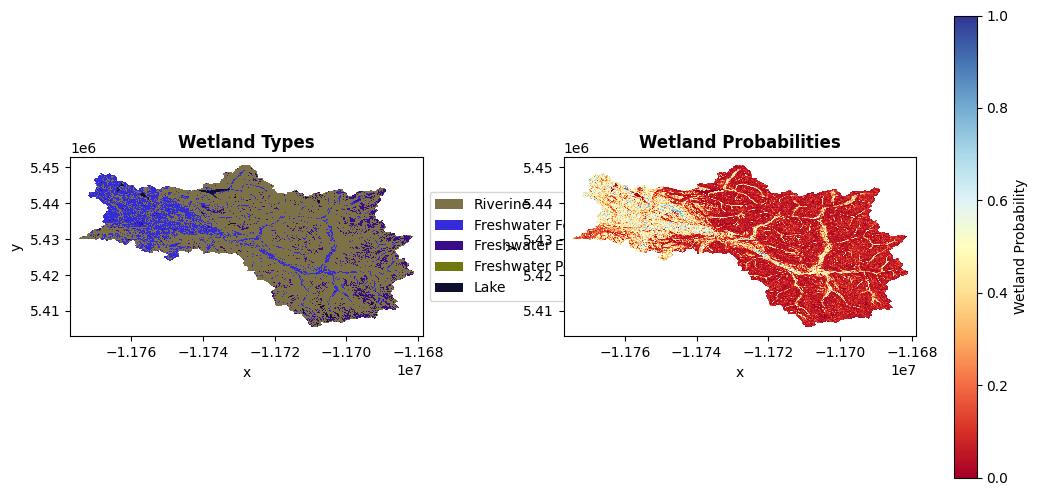

In [32]:
# Check if type_model exists
if "type_model" in locals():
    # Import the class label dictionary
    with open(f"data/{prefix}_labels_dict.json", "r") as json_file:
        labels_dict = json.load(json_file)
        # Remove the non-wetland class from the dictionary
        if "Non-wetland" in labels_dict:
            del labels_dict["Non-wetland"]

    # Generate random colors for each class (excluding class 0)
    random.seed(42)  # Set a seed for reproducibility
    class_colors = {
        class_name: f"#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}"
        for class_name in labels_dict
    }

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Sort classes based on their numeric labels
    sorted_classes = sorted(labels_dict, key=lambda x: labels_dict[x])

    # Define color map for the wetland type predictions
    cmap = ListedColormap([class_colors[class_name] for class_name in sorted_classes])

    # Plot wetland type predictions
    wetland_type_predictions.plot.imshow(
        ax=axes[0], cmap=cmap, add_colorbar=False, interpolation="none"
    )
    axes[0].set_title("Wetland Types", fontweight="bold")
    axes[0].set_aspect("equal")

    # Plot clipped wetland probabilities
    im = wetland_type_probabilities.plot.imshow(
        ax=axes[1], cmap="RdYlBu", add_colorbar=False, interpolation="none"
    )
    axes[1].set_title("Wetland Probabilities", fontweight="bold")
    axes[1].set_aspect("equal")

    # Add legend to the first subplot
    patches_list = [
        Patch(facecolor=class_colors[class_name]) for class_name in sorted_classes
    ]
    legend = axes[0].legend(
        patches_list,
        [class_name for class_name in sorted_classes],
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )

    # Adjust spacing
    plt.subplots_adjust(wspace=0.4)

    # Add colorbar outside the subplot
    cbar = fig.colorbar(
        im, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.05, pad=0.04
    )
    cbar.set_label("Wetland Probability")

    plt.show()
else:
    print("Skipping plotting process as wetland type model is not available.")

### Independent accuaracy assessment 

In [34]:
# Check if type_model exists
if "type_model" in locals():
    # Load the testing points GeoDataFrame
    testing_points = gpd.read_file(f"data/{prefix}_testing_samples.geojson").to_crs(
        wetland_type_predictions.rio.crs
    )

    # Sample the predictions and probabilities at testing points
    sampled_predictions = []
    sampled_probabilities = []

    for point in testing_points.geometry:
        # Extract the point coordinates
        x, y = point.x, point.y

        # Sample the binary predictions at the point coordinates
        prediction = wetland_type_predictions.sel(x=x, y=y, method="nearest").item()

        # Append the sampled values
        sampled_predictions.append(prediction)

    # Add the sampled values as new columns in the GeoDataFrame
    testing_points["sampled_predictions"] = sampled_predictions

    # Remove rows with NaN values for sampled predictions
    testing_points = testing_points.dropna(subset=["sampled_predictions"])

    # Calculate the number of correctly classified samples
    correct_count = (
        testing_points["sampled_predictions"] == testing_points["class_id"]
    ).sum()

    # Calculate the total number of samples
    total_count = len(testing_points)

    # Calculate the accuracy as a percentage
    accuracy_percentage = (correct_count / total_count) * 100

    # Print the accuracy percentage
    print(f"Overall Accuracy: {accuracy_percentage:.2f}%")
else:
    print("Skipping accuracy calculation as wetland type model is not available.")

Overall Accuracy: 25.20%


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")